## 训练方法说明:

由于本地计算资源有限（单个 epoch 训练时间约为 40 分钟），为了加快模型调试与参数调优过程，我采用了以下训练策略：

### 训练集处理：

1. 使用 CIFAR-10 原始训练集的前五个数据 batch 合并构建完整训练集；

2. 对所有图像进行标准化（均值归一化 + 方差归一化）；

3. 按照随机顺序划分出部分数据作为验证集。

### 验证集选取策略：

1. 为了在有限时间内观察模型性能变化趋势，我仅选用了约 1/20 的训练数据作为验证集（4000 张图像）；

2. 虽然验证集较小，但由于其为随机抽样，能够在一定程度上反映模型在整体数据上的性能变化趋势。

### 训练参数与策略：

1. 3 层卷积神经网络，参考博客资料采用 NAG（Nesterov 加速梯度）和 Adam进行优化；

2. 初始学习率设置为 1e-4，每轮乘以 0.96 进行学习率衰减；

3. 每轮训练后，在训练集与验证集上分别记录 loss 与 accuracy；

4. 自动保存验证集精度最优的模型副本，作为最终模型。

### 可视化与保存：

1. 训练结束后自动绘制训练/验证损失和精度曲线（但是由于第20轮后开始下坡路改为手动了orz）；

2. 保存训练好的最佳模型及其三层卷积核（RGB）可视化结果。

In [ ]:
## 导入库
import sys, os

sys.path.insert(1, os.path.split(os.path.split(sys.path[0])[0])[0])
import pickle as pkl
import numpy as np
from sklearn import preprocessing
from sklearn.utils import shuffle
from src.neural_net import NeuralNetwork
import matplotlib.pyplot as plt
from tools import save_model, plot_curves,visualize_conv_rgb_layer1, visualize_conv_rgb_layer2, visualize_conv_rgb_layer3
import copy

In [3]:
## 数据准备
def unpickle(file):
    with open(file, 'rb') as fo:
        return pkl.load(fo, encoding='latin1')


# 读取标签
le = preprocessing.LabelEncoder()
le.classes_ = unpickle(sys.path[0] + '/batches.meta')['label_names']

# 读取训练数据
train_images, train_labels = None, []
for i in range(1, 6):
    data = unpickle(sys.path[0] + '/data_batch_' + str(i))
    imgs = data['data'].reshape(-1, 3, 32, 32).astype(np.float64)
    lbls = data['labels']
    train_images = imgs if train_images is None else np.vstack((train_images, imgs))
    train_labels += lbls

# 归一化
mean_image = np.mean(train_images, axis=0)
std = np.std(train_images, axis=0)
train_images = ((train_images - mean_image) / std).astype(np.float32)

# 读取测试数据
data = unpickle(sys.path[0] + '/test_batch')
test_images = data['data'].reshape(-1, 3, 32, 32).astype(np.float64)
test_images = ((test_images - mean_image) / std).astype(np.float32)
test_labels = data['labels']



## 超参数调优

1. 之前在终端先每个跑了2个epoch大概估计了一个范围，然后由于我的电脑配置较烂且CNN网络运行时间很久（一个epoch大约需要40Min），所以调优时只划分出数据集的1/20进行测试，只关注accuracy和loss的变化趋势。

2. 似乎没有严格的理论保证趋势一定不变，但这里认为在实践中，如果验证集是随机抽样的，趋势通常能较好地反映整体情况。

3. 除零错误指示训练过程中存在数值不稳定性，后续避开了这些导致溢出/舍入误差的参数。

In [4]:
## 超参数调优
# 使用训练集的1/20
subset_len = len(train_images) // 20
train_images, train_labels = shuffle(train_images, train_labels)
train_images = train_images[:subset_len]
train_labels = train_labels[:subset_len]

# 参数组合
param_space = {
    'batch_size': [1, 8, 64],
    'lr': [1, 0.01, 0.0001],
    'learning_rate_decay': [1.0, 0.1, 0.01],
    'l2_reg': [1e-3, 1e-4, 1e-5]
}

# 当前最佳配置（原来在终端先跑了一遍了）
best_config = {
    'batch_size': 1,
    'lr': 1e-4,
    'learning_rate_decay': 1.0,
    'l2_reg': 1e-5
}
best_acc = 0


# 搜索
def evaluate_config(config):
    cnn = NeuralNetwork(train_images.shape[1:], [
        {'type': 'conv', 'k': 16, 'u_type': 'nag', 'f': 5, 's': 1, 'p': 2},
        {'type': 'pool', 'method': 'average'},
        {'type': 'conv', 'k': 20, 'u_type': 'nag', 'f': 5, 's': 1, 'p': 2},
        {'type': 'pool', 'method': 'average'},
        {'type': 'conv', 'k': 20, 'u_type': 'nag', 'f': 5, 's': 1, 'p': 2},
        {'type': 'pool', 'method': 'average'},
        {'type': 'output', 'k': len(le.classes_), 'u_type': 'adam'}
    ], config['lr'], l2_reg=config['l2_reg'])

    cnn.lr_decay = config['learning_rate_decay']
    cnn.epoch_count = 0
    cnn.t = 0

    for epoch in range(3):
        print(f"\n=== Epoch {epoch + 1} start... ===")
        images, labels = shuffle(train_images, train_labels)
        for i in range(0, len(images), config['batch_size']):
            batch_x = images[i:i+config['batch_size']]
            batch_y = labels[i:i+config['batch_size']]
            cnn.t += 1
            cnn.epoch(batch_x, batch_y)

        cnn.epoch_count += 1
        cnn.lr *= cnn.lr_decay

        train_loss, train_acc = cnn.predict(train_images, train_labels)
        test_loss, test_acc = cnn.predict(test_images[:500], test_labels[:500])

        print(f"=== Epoch {epoch + 1} finish. ===")
        print(f"Train acc: {train_acc:.4f}, Train loss: {train_loss:.4f}")
        print(f"Test acc: {test_acc:.4f}, Test loss: {test_loss:.4f}")

    # 返回最后一次评估的 test acc
    return test_acc, config


# 对每个参数进行调优
for key in ['batch_size', 'lr', 'learning_rate_decay', 'l2_reg']:
    values = param_space[key]
    print(f"Tuning {key}...")
    for v in values:
        config = best_config.copy()
        config[key] = v
        acc, tested_cfg = evaluate_config(config)
        print(f"{key}={v}, acc={acc}")
        if acc > best_acc:
            best_acc = acc
            best_config = tested_cfg
            print(">> New best config:", best_config, "acc=", acc)

print("=== Best Config Found ===")
print(best_config)
print("Best accuracy:", best_acc)

Tuning batch_size...

=== Epoch 1 start... ===
=== Epoch 1 finish. ===
Train acc: 33.6800, Train loss: 1.8761
Test acc: 29.8000, Test loss: 1.9790

=== Epoch 2 start... ===
=== Epoch 2 finish. ===
Train acc: 39.6400, Train loss: 1.7028
Test acc: 32.0000, Test loss: 1.8784

=== Epoch 3 start... ===
=== Epoch 3 finish. ===
Train acc: 41.9600, Train loss: 1.5976
Test acc: 35.6000, Test loss: 1.7743
batch_size=1, acc=35.6
>> New best config: {'batch_size': 1, 'lr': 0.0001, 'learning_rate_decay': 1.0, 'l2_reg': 1e-05} acc= 35.6

=== Epoch 1 start... ===
=== Epoch 1 finish. ===
Train acc: 11.5600, Train loss: 2.3650
Test acc: 10.6000, Test loss: 2.4169

=== Epoch 2 start... ===
=== Epoch 2 finish. ===
Train acc: 15.0400, Train loss: 2.2952
Test acc: 13.4000, Test loss: 2.3235

=== Epoch 3 start... ===
=== Epoch 3 finish. ===
Train acc: 18.0000, Train loss: 2.2198
Test acc: 16.2000, Test loss: 2.2473
batch_size=8, acc=16.2

=== Epoch 1 start... ===
=== Epoch 1 finish. ===
Train acc: 11.5200, 

c:\Users\lenovo\PycharmProjects\CV2.0\Project1\classes\utils.py:12: RuntimeWarning: divide by zero encountered in log
  loss = -np.sum(np.log(probs[range(N), y])) / N
c:\Users\lenovo\PycharmProjects\CV2.0\Project1\classes\utils.py:88: RuntimeWarning: overflow encountered in square
  n.v = beta2 * n.v + (1 - beta2) * (dx**2)
c:\Users\lenovo\PycharmProjects\CV2.0\Project1\classes\neuron.py:15: RuntimeWarning: overflow encountered in square
  return np.sum(np.square(self.weights))
d:\Anaconda\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


=== Epoch 1 finish. ===
Train acc: 9.2400, Train loss: nan
Test acc: 11.4000, Test loss: nan

=== Epoch 2 start... ===
=== Epoch 2 finish. ===
Train acc: 9.2400, Train loss: nan
Test acc: 11.4000, Test loss: nan

=== Epoch 3 start... ===
=== Epoch 3 finish. ===
Train acc: 9.2400, Train loss: nan
Test acc: 11.4000, Test loss: nan
lr=1, acc=11.4

=== Epoch 1 start... ===
=== Epoch 1 finish. ===
Train acc: 10.5200, Train loss: 2.3006
Test acc: 9.8000, Test loss: 2.3043

=== Epoch 2 start... ===
=== Epoch 2 finish. ===
Train acc: 11.1200, Train loss: 2.3001
Test acc: 9.6000, Test loss: 2.3045

=== Epoch 3 start... ===
=== Epoch 3 finish. ===
Train acc: 11.1200, Train loss: 2.3005
Test acc: 9.6000, Test loss: 2.3064
lr=0.01, acc=9.6

=== Epoch 1 start... ===
=== Epoch 1 finish. ===
Train acc: 28.7600, Train loss: 1.9327
Test acc: 27.4000, Test loss: 2.0275

=== Epoch 2 start... ===
=== Epoch 2 finish. ===
Train acc: 33.6000, Train loss: 1.8274
Test acc: 26.6000, Test loss: 1.9601

=== Epoch

更新后的最优参数为
```
{'batch_size': 1, 
'lr': 0.0001, 
'learning_rate_decay': 1.0, 
'l2_reg': 1e-05}，
```

在服务器终端进行了一些更细节的调优，同时参考了一些博客的参数，最后得到
```
best_config = {
    'batch_size': 1,
    'lr': 1e-4,
    'learning_rate_decay': 96e-2,
    'l2_reg': 8e-6
}
```
用于训练。（ps防止数据丢失把训练结果粘贴在下面了）

Epoch 1/30 - lr=0.000100  
Train Loss: 1.3000 | Train Acc: 54.6000  
Val   Loss: 1.3536 | Val   Acc: 52.5750  
--> New best model saved (val acc = 52.5750)

Epoch 2/30 - lr=0.000096  
Train Loss: 1.1725 | Train Acc: 58.5500  
Val   Loss: 1.1968 | Val   Acc: 57.8000  
--> New best model saved (val acc = 57.8000)

Epoch 3/30 - lr=0.000092  
Train Loss: 1.0704 | Train Acc: 63.3250  
Val   Loss: 1.1337 | Val   Acc: 60.5250  
--> New best model saved (val acc = 60.5250)

Epoch 4/30 - lr=0.000088  
Train Loss: 0.9995 | Train Acc: 65.0250  
Val   Loss: 1.0740 | Val   Acc: 62.8750  
--> New best model saved (val acc = 62.8750)

Epoch 5/30 - lr=0.000085  
Train Loss: 0.9661 | Train Acc: 66.0250  
Val   Loss: 1.0292 | Val   Acc: 63.6750  
--> New best model saved (val acc = 63.6750)

Epoch 6/30 - lr=0.000082  
Train Loss: 0.9168 | Train Acc: 68.3500  
Val   Loss: 0.9788 | Val   Acc: 65.9250  
--> New best model saved (val acc = 65.9250)

Epoch 7/30 - lr=0.000078  
Train Loss: 0.8876 | Train Acc: 68.6000  
Val   Loss: 0.9563 | Val   Acc: 66.2000  
--> New best model saved (val acc = 66.2000)

Epoch 8/30 - lr=0.000075  
Train Loss: 0.8177 | Train Acc: 71.2000  
Val   Loss: 0.9098 | Val   Acc: 68.1500  
--> New best model saved (val acc = 68.1500)

Epoch 9/30 - lr=0.000072  
Train Loss: 0.8600 | Train Acc: 70.7000  
Val   Loss: 0.9158 | Val   Acc: 67.2750

Epoch 10/30 - lr=0.000069  
Train Loss: 0.7584 | Train Acc: 74.2500  
Val   Loss: 0.8818 | Val   Acc: 69.1000  
--> New best model saved (val acc = 69.1000)

Epoch 11/30 - lr=0.000066  
Train Loss: 0.7242 | Train Acc: 75.5750  
Val   Loss: 0.8568 | Val   Acc: 70.1000  
--> New best model saved (val acc = 70.1000)

Epoch 12/30 - lr=0.000064  
Train Loss: 0.7343 | Train Acc: 74.4000  
Val   Loss: 0.8267 | Val   Acc: 71.7500  
--> New best model saved (val acc = 71.7500)

Epoch 13/30 - lr=0.000061  
Train Loss: 0.6809 | Train Acc: 76.5500  
Val   Loss: 0.8413 | Val   Acc: 70.6750

Epoch 14/30 - lr=0.000059  
Train Loss: 0.7231 | Train Acc: 75.4000  
Val   Loss: 0.8590 | Val   Acc: 70.2250

Epoch 15/30 - lr=0.000056  
Train Loss: 0.6981 | Train Acc: 75.7500  
Val   Loss: 0.8366 | Val   Acc: 71.0000

Epoch 16/30 - lr=0.000054  
Train Loss: 0.6525 | Train Acc: 77.0000  
Val   Loss: 0.8309 | Val   Acc: 71.6250

Epoch 17/30 - lr=0.000052  
Train Loss: 0.6549 | Train Acc: 77.4250  
Val   Loss: 0.8173 | Val   Acc: 71.4750

Epoch 18/30 - lr=0.000050  
Train Loss: 0.6666 | Train Acc: 77.4000  
Val   Loss: 0.8299 | Val   Acc: 71.6500

Epoch 19/30 - lr=0.000048  
Train Loss: 0.6298 | Train Acc: 78.6750  
Val   Loss: 0.8182 | Val   Acc: 72.0250  
--> New best model saved (val acc = 72.0250)

Epoch 20/30 - lr=0.000046  
Train Loss: 0.6096 | Train Acc: 78.0250  
Val   Loss: 0.8175 | Val   Acc: 71.9000

Epoch 21/30 - lr=0.000044  
Train Loss: 0.6357 | Train Acc: 77.8000  
Val   Loss: 0.8244 | Val   Acc: 71.5750


训练到第20轮的时候发现loss开始回升了而且accuracy从之前就提升幅度很小，所以提前停止训练。

In [ ]:
import sys, os
sys.path.insert(1, os.path.split(os.path.split(sys.path[0])[0])[0])

import pickle as pkl
import numpy as np
from sklearn import preprocessing
from sklearn.utils import shuffle
from src.neural_net import NeuralNetwork
from tools import save_model, plot_curves, visualize_conv_rgb_layer1, visualize_conv_rgb_layer2, visualize_conv_rgb_layer3
import copy

# ---------- 数据处理 ----------
def unpickle(file):
    with open(file, 'rb') as fo:
        return pkl.load(fo, encoding='latin1')

le = preprocessing.LabelEncoder()
le.classes_ = unpickle(sys.path[0] + '/batches.meta')['label_names']

# 加载训练数据
train_images, train_labels = None, []
for i in range(1, 6):
    data = unpickle(sys.path[0] + f'/data_batch_{i}')
    train_images = data['data'] if train_images is None else np.vstack((train_images, data['data']))
    train_labels += data['labels']

train_images = train_images.reshape(-1, 3, 32, 32).astype(np.float64)
mean_image = np.mean(train_images, axis=0)
std = np.std(train_images, axis=0)
train_images = ((train_images - mean_image) / std).astype(np.float32)

# 验证集划分
train_images, train_labels = shuffle(train_images, train_labels, random_state=42)
val_images = train_images[:4000]
val_labels = train_labels[:4000]
train_images = train_images[4000:]
train_labels = train_labels[4000:]

# 测试集处理
test_data = unpickle(sys.path[0] + '/test_batch')
test_images = test_data['data'].reshape(-1, 3, 32, 32).astype(np.float64)
test_images = ((test_images - mean_image) / std).astype(np.float32)
test_labels = test_data['labels']

# ---------- 模型超参数 ----------
lr = 1e-4
l2_reg = 8e-6
decay = 0.96
batch_size = 1
num_epochs = 30

cnn = NeuralNetwork(
    train_images.shape[1:],
    [
        {'type': 'conv', 'k': 16, 'u_type': 'nag', 'f': 5, 's': 1, 'p': 2},
        {'type': 'pool', 'method': 'average'},
        {'type': 'conv', 'k': 20, 'u_type': 'nag', 'f': 5, 's': 1, 'p': 2},
        {'type': 'pool', 'method': 'average'},
        {'type': 'conv', 'k': 20, 'u_type': 'nag', 'f': 5, 's': 1, 'p': 2},
        {'type': 'pool', 'method': 'average'},
        {'type': 'output', 'k': len(le.classes_), 'u_type': 'adam'}
    ],
    lr, l2_reg=l2_reg
)

# ---------- 训练主循环 ----------
best_model = None
best_val_acc = 0

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    # Shuffle 每个 epoch
    train_images, train_labels = shuffle(train_images, train_labels)

    # mini-batch 训练
    for i in range(0, len(train_images), batch_size):
        x_batch = train_images[i:i+batch_size]
        y_batch = train_labels[i:i+batch_size]
        cnn.t += 1
        loss, acc = cnn.epoch(x_batch, y_batch)

    # epoch 完成：评估
    train_loss, train_acc = cnn.predict(train_images[:4000], train_labels[:4000])
    val_loss, val_acc = cnn.predict(val_images, val_labels)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} - lr={cnn.lr:.6f}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")

    # 保存最优模型
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model = copy.deepcopy(cnn)
        print(f"--> New best model saved (val acc = {val_acc:.4f})")

    # 衰减学习率
    cnn.lr *= decay

# ---------- 测试集评估 ----------
test_loss, test_acc = best_model.predict(test_images, test_labels)
print(f"\nFinal Test Accuracy: {test_acc:.4f} | Loss: {test_loss:.4f}")

# ---------- 保存模型 ----------
save_model(best_model, "best_model.pkl")
print(f"\nBest model saved as 'best_model.pkl' with val acc = {best_val_acc:.4f}")

# ---------- 可视化 ----------
plot_curves(train_losses, val_losses, train_accs, val_accs)

print("First Layer Conv Kernels:")
visualize_conv_rgb_layer1(best_model.layers[0], 16)

print("Second Layer Conv Kernels:")
visualize_conv_rgb_layer2(best_model.layers[2], 20)

print("Third Layer Conv Kernels:")
visualize_conv_rgb_layer3(best_model.layers[4], 20)



Epoch 1/30 - lr=0.000100
Train Loss: 1.3000 | Train Acc: 54.6000
Val   Loss: 1.3536 | Val   Acc: 52.5750
--> New best model saved (val acc = 52.5750)
Epoch 2/30 - lr=0.000096
Train Loss: 1.1725 | Train Acc: 58.5500
Val   Loss: 1.1968 | Val   Acc: 57.8000
--> New best model saved (val acc = 57.8000)
Epoch 3/30 - lr=0.000092
Train Loss: 1.0704 | Train Acc: 63.3250
Val   Loss: 1.1337 | Val   Acc: 60.5250
--> New best model saved (val acc = 60.5250)
Epoch 4/30 - lr=0.000088
Train Loss: 0.9995 | Train Acc: 65.0250
Val   Loss: 1.0740 | Val   Acc: 62.8750
--> New best model saved (val acc = 62.8750)
Epoch 5/30 - lr=0.000085
Train Loss: 0.9661 | Train Acc: 66.0250
Val   Loss: 1.0292 | Val   Acc: 63.6750
--> New best model saved (val acc = 63.6750)
Epoch 6/30 - lr=0.000082
Train Loss: 0.9168 | Train Acc: 68.3500
Val   Loss: 0.9788 | Val   Acc: 65.9250
--> New best model saved (val acc = 65.9250)
Epoch 7/30 - lr=0.000078
Train Loss: 0.8876 | Train Acc: 68.6000
Val   Loss: 0.9563 | Val   Acc: 66.

KeyboardInterrupt: 

In [28]:
save_model(best_model, "best_model.pkl")
print(f"\nBest model saved as 'best_model.pkl' with val acc = {best_val_acc:.4f}")


Model saved to best_model.pkl

Best model saved as 'best_model.pkl' with val acc = 72.0250


## 模型训练过程分析

下图展示了模型在训练过程中 Loss 与 Accuracy 的变化趋势：

### 左图：Loss Curve

1. Train Loss（蓝线）持续下降，说明模型在训练集上收敛良好；

2. Validation Loss（橙线）也总体下降，但从第 10 个 epoch 左右开始，下降幅度趋于平缓，甚至略有震荡；可能是由于：模型在训练集上拟合能力增强，但是在验证集上出现轻微过拟合趋势，但整体仍在可接受范围内。

### 右图：Accuracy Curve
1. Train Accuracy（绿线）持续上升，达到约 78%，验证训练有效；

2. Validation Accuracy（红线）也稳步提升，最终稳定在 72% 左右；

训练与验证精度之间存在一定差距，暗示模型可能略有过拟合，但尚未失控。

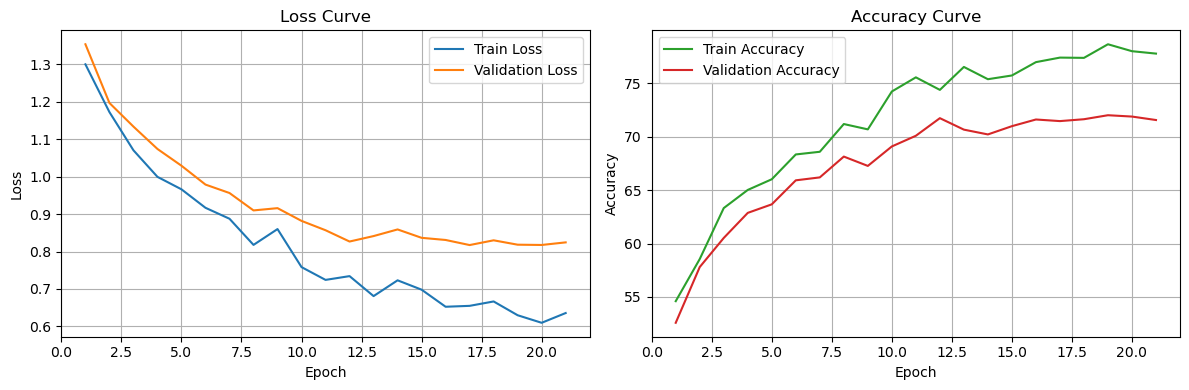

In [29]:
plot_curves(train_losses, val_losses, train_accs, val_accs)


## 测试

导入训练好的模型进行测试，在test集上的accuracy为71.41，loss为0.8373

In [30]:
test_loss, test_acc = best_model.predict(test_images, test_labels)
print(f"\nFinal Test Accuracy: {test_acc:.4f} | Loss: {test_loss:.4f}")



Final Test Accuracy: 71.4100 | Loss: 0.8373


## 卷积核可视化分析
下图展示了训练完成后的模型各层卷积核的可视化效果（RGB 视角）：

### 第一层卷积核（Conv Layer 1）

该层接收到的是原始图像像素输入，主要提取低级特征，如边缘、颜色、方向、纹理等；

卷积核整体色彩分明、形状清晰，说明网络已经成功学习到了一些基础的图像局部特征；

部分卷积核具有强烈的方向性（如水平/垂直边缘检测）。

### 第二层卷积核（Conv Layer 2）

第二层卷积核以第一层输出的特征图为输入，进一步组合低级特征；

图像看起来比第一层更复杂，出现更多模糊的颜色混合和局部模式；

开始形成对局部纹理、简单组合结构的响应。

### 第三层卷积核（Conv Layer 3）

第三层是更深层的卷积操作，卷积核的可视化效果更加抽象；

难以直观识别具体模式，说明该层捕捉的是更高阶的抽象特征，有助于模型完成更复杂的分类决策。

First Layer Conv Kernels:


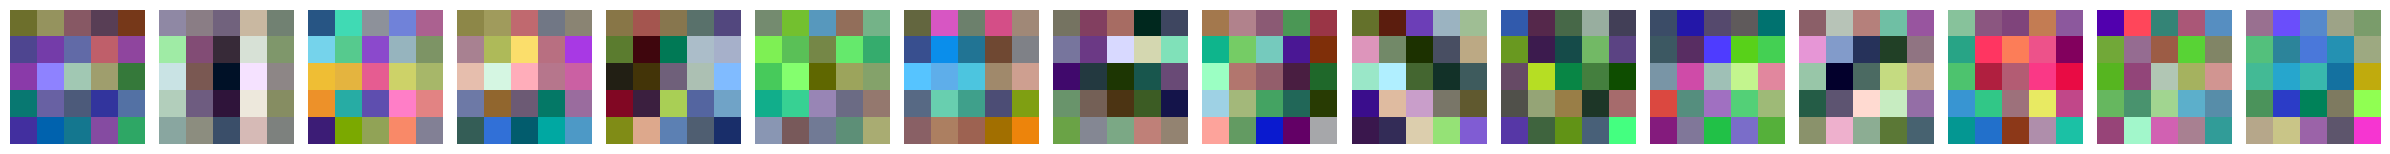

Second Layer Conv Kernels:


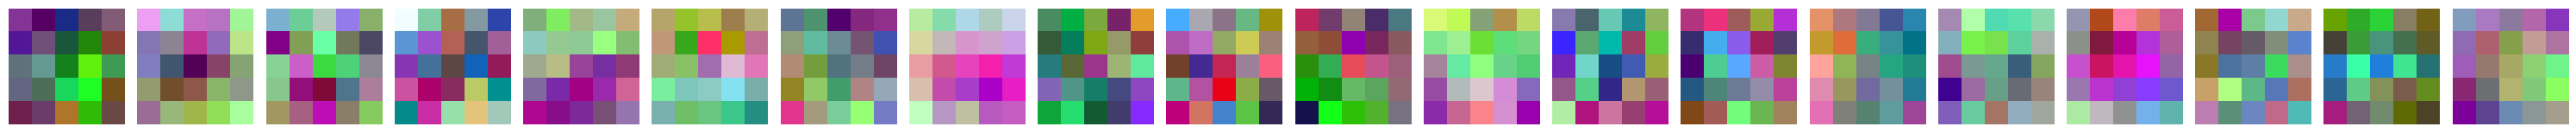

Third Layer Conv Kernels:


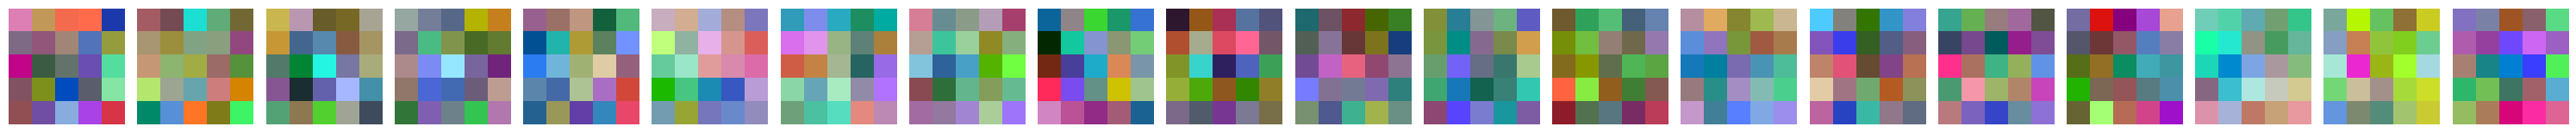

In [31]:
print("First Layer Conv Kernels:")
visualize_conv_rgb_layer1(best_model.layers[0], 16)

print("Second Layer Conv Kernels:")
visualize_conv_rgb_layer2(best_model.layers[2], 20)

print("Third Layer Conv Kernels:")
visualize_conv_rgb_layer3(best_model.layers[4], 20)
